Using TensorFlow backend.


Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 129, 100, 1)
conv1 		 (?, 129, 100, 16)
deconv	 (?, ?, ?, 2)
Model consits of  19218 trainable parameters.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in log10


[[  3.39067938e+05   7.58943672e+04   0.00000000e+00 ...,   1.27869120e+08
    9.21377920e+07   6.98368640e+07]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   8.71678320e+07
    6.14100240e+07   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   1.34032672e+08
    6.50388560e+07   0.00000000e+00]
 ..., 
 [  0.00000000e+00   1.50007792e+01   0.00000000e+00 ...,   0.00000000e+00
    1.23161011e+01   1.17839384e+01]
 [  2.73476524e+01   1.75694294e+01   0.00000000e+00 ...,   2.55889177e+00
    0.00000000e+00   9.97668648e+00]
 [  2.37202377e+01   1.98507233e+01   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   3.52054656e-01]]


/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:860: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:861: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


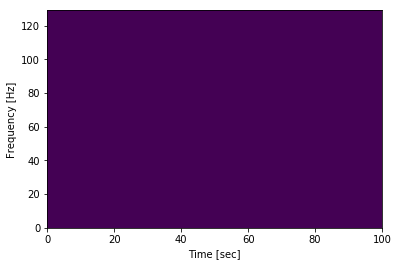

Forward pass successful!
Begin training loop
Epoch 1 : Train Loss 12749566394761216.000, Valid loss 11834635281498112.000
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   6.85858850e+06
    3.47312200e+06   2.15469725e+06]
 [  1.58531958e+03   6.05550000e+03   0.00000000e+00 ...,   0.00000000e+00
    2.09427862e+06   0.00000000e+00]
 [  1.28524561e+03   0.00000000e+00   0.00000000e+00 ...,   1.94838359e+05
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   5.92192125e+00   7.33740616e+01 ...,   2.45492752e+02
    0.00000000e+00   1.42607617e+03]
 [  0.00000000e+00   0.00000000e+00   2.73037891e+01 ...,   4.03688904e+02
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   4.96426964e+01 ...,   7.95178345e+02
    0.00000000e+00   0.00000000e+00]]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:860: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:861: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


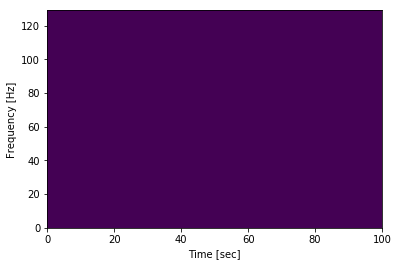

(<matplotlib.text.Text at 0x7fbcb85c7b00>,
 (0.75, 1.03))

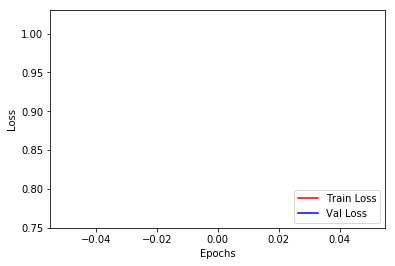

In [1]:
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf
import utils
from librispeech_mixer import LibriSpeechMixer
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose


tf.reset_default_graph()

height, width, nchannels = 129, 100, 1
padding = 'same'

filters_1 = 16
kernel_size_1 = (20,20)
pool_size_1 = (2,2)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, height, width, 2], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    """pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    x = flatten(x)
    print('Flatten \t', x.get_shape())"""



with tf.variable_scope('output_layer'):
    deconv = Conv2DTranspose(2, kernel_size_1, strides=(1,1), padding=padding, activation='relu')

    y = deconv(x)
    print('deconv\t', y.get_shape())

print('Model consits of ', utils.num_params(), 'trainable parameters.')

gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)

"""## Launch TensorBoard, and visualize the TF graph

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
    utils.show_graph(tmp_def)"""


with tf.variable_scope('loss'):
    # computing cross entropy per sample
    mean_square_error = tf.reduce_mean((y_pl - y) ** 2)



with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(mean_square_error)


#Create the LibriSpeech mixer
mixer = LibriSpeechMixer()
width = mixer.spec_length
validation_mixer = LibriSpeechMixer(False)

#Test the forward pass
x_batch, y_batch = mixer.get_batch(2)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
# with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})
    
    plt.pcolormesh(10 * np.log10(y_pred[0,:,:,0]))
    print(y_pred[0,:,:,0])
    plt.axis('tight')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
assert y_pred.shape == y_batch.shape, "ERROR the output shape is not as expected!"         + " Output shape should be " + str(y.shape) + ' but was ' + str(y_pred.shape)

print('Forward pass successful!')


# ## Training

#Training Loop
batch_size = 2
max_epochs = 1


valid_loss = []
train_loss = []
test_loss = []
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)

def trainingLoog():
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
        sess.run(tf.global_variables_initializer())
        print('Begin training loop')

        try:

            while mixer.epochs_completed < max_epochs:
                _train_loss = []

                ## Run train op
                x_batch, y_batch = mixer.get_batch(batch_size)
                fetches_train = [train_op, mean_square_error]
                feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
                _, _loss = sess.run(fetches_train, feed_dict_train)

                _train_loss.append(_loss)

                ## Compute validation loss
                if mixer.index_in_epoch <= batch_size:
                    _valid_loss = []
                    train_loss.append(np.mean(_train_loss))

                    fetches_valid = [mean_square_error]

                    while validation_mixer.epochs_completed <= mixer.epochs_completed:
                        x_valid, y_valid = validation_mixer.get_batch(batch_size)
                        feed_dict_valid = {x_pl: x_valid, y_pl: y_valid}
                        _loss = sess.run(fetches_valid, feed_dict_valid)

                        _valid_loss.append(_loss)

                    valid_loss.append(np.mean(_valid_loss))


                    print("Epoch {} : Train Loss {:6.3f}, Valid loss {:6.3f}".format(
                        mixer.epochs_completed, train_loss[-1], valid_loss[-1]))

        
        except KeyboardInterrupt:
            pass
        
        y_pred = sess.run(fetches=x, feed_dict={x_pl: x_batch})
    
        plt.pcolormesh(10 * np.log10(y_pred[0,:,:,0]))
        print(y_pred[0,:,:,0])
        plt.axis('tight')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()
    
trainingLoog();


    
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss,'r', epoch, valid_loss,'b')
plt.legend(['Train Loss','Val Loss'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.ylim([0.75,1.03])

In [18]:
x_batch, y_batch = mixer.get_batch(10)
print(x_batch[0])

[[[  4.44380156e+04]
  [  6.86100293e+03]
  [  1.70777812e+04]
  ..., 
  [  2.08476750e+05]
  [  7.19965250e+05]
  [  4.80572094e+05]]

 [[  2.30187025e+06]
  [  3.94549925e+06]
  [  2.37678781e+05]
  ..., 
  [  1.03267030e+07]
  [  9.38457100e+06]
  [  1.11344152e+08]]

 [[  4.33599625e+05]
  [  5.53545750e+05]
  [  3.19705469e+05]
  ..., 
  [  2.19563797e+05]
  [  2.45086425e+06]
  [  9.63508480e+07]]

 ..., 
 [[  6.43919189e+02]
  [  1.10687268e+03]
  [  2.13324509e+01]
  ..., 
  [  1.10534204e+03]
  [  7.41937891e+03]
  [  1.02559436e+03]]

 [[  6.28781548e+01]
  [  9.23847412e+02]
  [  6.11578186e+02]
  ..., 
  [  6.16732461e+04]
  [  1.80806973e+04]
  [  1.68554551e+04]]

 [[  3.03929787e+01]
  [  1.12523987e+03]
  [  9.80466366e+00]
  ..., 
  [  4.30169062e+04]
  [  7.45112061e+03]
  [  7.66773047e+03]]]
